# National Stablecoin



In [1]:
from cadCAD.configuration import Experiment
from cadCAD.configuration.utils import config_sim
from cadCAD.configuration import Configuration
from cadCAD.engine import ExecutionMode, ExecutionContext, Executor
import pandas as pd
import numpy as np

In [2]:
MONTE_CARLO_RUNS = 1
SIMULATION_TIMESTEPS = 100
FOO = 3

genesis_states = {
    'fiat_value': 0
    #'risky_asset_value': 0,
    #'risk_free_asset_value':0,
    #'investor_total_shares': 0
}

def p_buy_stablecoin(params, 
                step, 
                state_history, 
                prev_state):
    amount = np.random.rand()
    return {'fiat': amount}

def s_increment_fiat(params, 
                step, 
                state_history, 
                prev_state, _input):
    amount = _input['fiat']
    key = 'fiat_value'
    value = prev_state[key] + amount
    return (key,value)


partial_state_update_blocks = [
    {
        'policies': {
            'buy_stablecoin': p_buy_stablecoin
            
        },
        'variables': {
            'fiat_value': s_increment_fiat
        }
    }
]

sim_config = {
    'N': MONTE_CARLO_RUNS,
    'T': range(SIMULATION_TIMESTEPS),
}

In [3]:
sim_params = config_sim(sim_config)

exp = Experiment()
exp.append_configs(
    sim_configs=sim_params,
    initial_state=genesis_states,
    partial_state_update_blocks=partial_state_update_blocks
)

exec_mode = ExecutionMode()
local_mode_ctx = ExecutionContext(context=exec_mode.local_mode)

simulation = Executor(exec_context=local_mode_ctx,
                      configs=exp.configs)
raw_system_events, tensor_field, sessions = simulation.execute()


                  ___________    ____
  ________ __ ___/ / ____/   |  / __ \
 / ___/ __` / __  / /   / /| | / / / /
/ /__/ /_/ / /_/ / /___/ ___ |/ /_/ /
\___/\__,_/\__,_/\____/_/  |_/_____/
by cadCAD

cadCAD Version: 0.4.28
Execution Mode: local_proc
Simulation Dimensions:
Entire Simulation: (Models, Unique Timesteps, Params, Total Runs, Sub-States) = (1, 100, 0, 1, 1)
     Simulation 0: (Timesteps, Params, Runs, Sub-States) = (100, 0, 1, 1)
Execution Method: local_simulations
Execution Mode: single_threaded
Total execution time: 0.01s


In [4]:
df = pd.DataFrame(raw_system_events)

In [5]:
df

,fiat_value,simulation,subset,run,substep,timestep
0,0.000000,0,0,1,0,0
1,0.731171,0,0,1,1,1
2,1.669586,0,0,1,1,2
3,2.165877,0,0,1,1,3
4,2.690082,0,0,1,1,4
...,...,...,...,...,...,...
96,50.137492,0,0,1,1,96
97,50.693709,0,0,1,1,97
98,50.844528,0,0,1,1,98
99,50.944962,0,0,1,1,99


In [6]:
import matplotlib.pyplot as plt

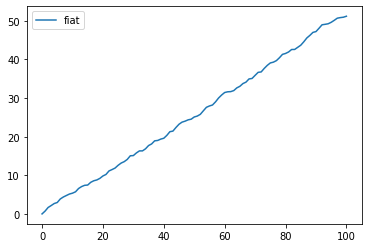

In [7]:
plt.plot(df.index, df.fiat_value.values)
plt.legend(['fiat'])